# plots used in the paper

## missing pairs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from notebook_load_functions import *

In [3]:
proxies = ['vpeak', 'vmax', 'mvir', 'macc']
cases = ['c250-2048', 'c250-1024', 'c250-768', 'c250-512','c250-2560',
         'c400-2048', 'c400-1024', 'c400-768', 'c125-2048', 'c125-1024']
nd_log_list = np.linspace(-3.3, -1.7, 17)

rbins = np.logspace(-1.3, 1.3, 27)

In [5]:
plt.rcdefaults()
%matplotlib inline
plt.rcParams['font.size'] = 16.0
plt.rcParams['font.family'] = 'serif'
plt.rcParams['legend.numpoints'] = 1

In [6]:
cases = ['c250-2048','c250-1024', 'c250-768', 'c250-512','c125-1024','c400-1024','c400-768']
#cases = ['c250-1024', 'c250-768', 'c250-512','c400-1024']
Npartperhalo = np.zeros((len(cases),len(nd_log_list)))
for j,case in enumerate(cases):
    cut = load_nd_limits('mvir', case)
    mass = parse_boxname(case)[2]
    Npartperhalo[j] = cut/mass

misspairs = np.zeros((len(proxies), len(cases),len(nd_log_list),len(rbins[1::2])))
for i,proxy in enumerate(proxies):
    for j,case in enumerate(cases):
        box_size, mass = parse_boxname(case)[1:]
        for k, nd_log in enumerate(nd_log_list):
            low = load_pair_count(proxy, case, nd_log)
            if box_size == 250.:
                high = load_pair_count(proxy, case.partition('-')[0]+'-2560', nd_log)
            else:
                high = load_pair_count(proxy, case.partition('-')[0]+'-2048', nd_log)
            misspairs[i,j,k] = (low-high)/high
'''
# remove Npph < 10
for i,ii in enumerate(Npartperhalo):
    for j,jj in enumerate(ii):
        if jj < 10:
            print i,j, jj
'''
Npartperhalo[6,16] = np.nan
misspairs[:,6,16,:] = np.nan

from scipy.optimize import curve_fit
def closest_ridx(r):
    return np.abs(rbins[1::2]-r).argmin()
def closest_ndidx(nd):
    return np.abs(nd_log_list-nd).argmin()
def fitmiss(x,a):
    return np.exp(-a/x) - 1.
def remove_nan(arr):
    return arr[arr==arr]

alist = np.zeros((len(proxies), len(rbins[1::2])))
for pidx, proxy in enumerate(proxies):
    for ridx, r in enumerate(rbins[1::2]):
        alist[pidx,ridx] = curve_fit(fitmiss, remove_nan(Npartperhalo.flatten()), remove_nan(misspairs[pidx,:,:,ridx].flatten()), p0=0.03)[0]

from scipy import interpolate
a_interpolate = [[] for i in range(4)]
for i in range(len(proxies)):
    a_interpolate[i] = interpolate.interp1d(rbins[1::2], alist[i])

def missing_pairs_int(proxy, Npph, r):
    return fitmiss(Npph, a_interpolate[proxies.index(proxy)](r))

/u/ki/iameric/miniconda/lib/python2.7/site-packages/matplotlib/scale.py:93: RuntimeWarning: invalid value encountered in less_equal
  mask = a <= 0.0


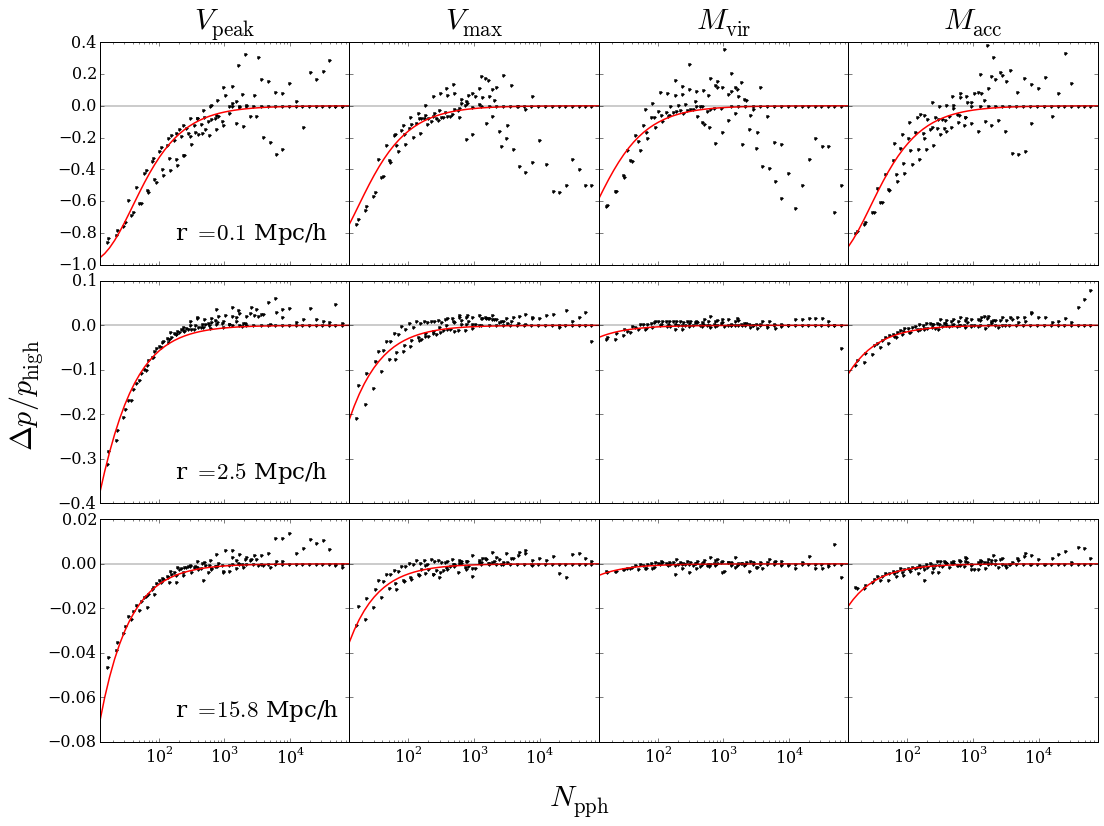

In [7]:
cases_sorted = ['c250-2048','c250-1024', 'c250-768', 'c250-512','c125-1024','c400-1024']
#cases_sorted = ['c250-768', 'c250-512','c400-1024']
cases_sorted = sorted(cases_sorted, key=lambda case: parse_boxname(case)[2], reverse=True)


proxy = 'macc'
proxies = ['vpeak', 'vmax', 'mvir', 'macc']
pidx = proxies.index(proxy)
scales = (0.07,2.5,15.)
#scales = rbins[1::2][::3]


fig, ax = plt.subplots(ncols = len(proxies) , nrows=len(scales),  figsize=(4*len(proxies), 4.*len(scales)),\
                       sharex=True, sharey='row')
#fig.subplots_adjust(wspace=0)

for ii, (axarr, r) in enumerate(zip(ax, scales)):
    ridx = closest_ridx(r)
    for jj, (ax_this, proxy) in enumerate(zip(axarr, proxies)):
        pidx = proxies.index(proxy)

        ax_this.semilogx(Npartperhalo.flatten(), misspairs[pidx,:,:,ridx].flatten(), '.', \
                         label='nd='+str(nd_log), alpha=1.0,c='k')
        Npartlist = np.logspace(1.1,4.9,51)
        ax_this.semilogx(Npartlist, [missing_pairs_int(proxy, n, r) for n in Npartlist], c = 'r', lw = 1.5)
        ax_this.axhline(0, c='k', lw=0.4)
        if ii==0: ax_this.set_title(r'${0}_{{\rm {1}}}$'.format(proxy[0].upper(), proxy[1:]), fontsize=30,y=1.04);
        if jj==0: ax_this.text(0.3, 0.2, r'r $ = {0:.1f}$ Mpc/h'.format(rbins[1::2][closest_ridx(r)]), \
                               transform=ax_this.transAxes,va='top', fontsize='x-large');
        if ii==0: ax_this.set_ylim(-1., 0.4)
        ax_this.set_xlim(Npartlist[0], Npartlist[-1])

plt.tight_layout(0, rect=(0.04, 0.07, 0.95, 0.95));
fig.text(0.02, 0.5, r'$\Delta p/  p_{\rm high}$', ha='center', va='center', rotation='vertical', fontsize=30);
fig.text(0.5, 0.03, r'$N_{{\rm pph}}$', ha='center', va='center', fontsize=30);
#fig.text(0.5, 0.95, r'$ \rm  {0} \, missing \, pairs  =\exp(-A(r) \times 1/N_{{\rm PperHalo}})-1$'.format(proxy), ha='center', va='center', fontsize='x-large');
#fig.text(0.5, 0.95, r'${\rm V_{peak} \, missing \, pairs}=\exp(-(A-B \log(r))^C \times 1/N_{{\rm PperHalo}})-1$', ha='center', va='center', fontsize='x-large');
#plt.savefig('plots/paper/missingpairs_Npperhalo.pdf')

## sample variance

In [9]:
case = 'MDhigh'
proxies = ['vpeak', 'vmax', 'mvir', 'macc']
box_size_this = (100.,111., 125.,142., 166.,200.,250.,333.)
box_size_high = (100.,111., 125.,142., 166.,200.,250.,333.)
x = 0.5*(rbins[:-1] + rbins[1:])
error = np.zeros((len(box_size_this), len(nd_log_list),len(proxies), len(x)))

for i, box_size in enumerate(box_size_this):
    for j, nd_log in enumerate(nd_log_list):
        for k, proxy in enumerate(proxies):
            samples = load_samples(proxy, nd_log, box_size, case)
            y = np.std(samples, axis=0)/np.mean(samples, axis=0)
            y_poisson = 1/np.sqrt(np.mean(samples, axis=0))
            error[i,j,k] = y**2 - y_poisson**2
            #error[i,j,k] = np.std(samples, axis=0)/np.mean(samples, axis=0)

from scipy.optimize import curve_fit
def fitfunc(x,a,b,c):
    return a + b*x**-c
def fitfunc2(x,b,c):
    return b*x**-c

x = 0.5*(rbins[1:]+rbins[:-1])

clist = np.zeros((len(proxies), len(x),3))
#clist = np.zeros((len(x),2))
for i,proxy in enumerate(proxies):
    for j,r in enumerate(x):
        if proxy == 'vpeak' and r > 0.1:
            if 0.1 < r and r < 0.35:
                nd_cut = 5
            elif r > 0.35:
                nd_cut = 0
            clist[i,j] = curve_fit(fitfunc, 10.**nd_log_list[nd_cut:], error[0,nd_cut:,i,j],p0=[0.005,3e-6,1.05],\
                                   bounds = ([0,0,0],[np.inf, np.inf, np.inf]))[0]
        elif r > 0.4:
            clist[i,j] = curve_fit(fitfunc, 10.**nd_log_list, error[0,:,i,j],p0=[0.005,3e-6,1.05],\
                                   bounds = ([0,0,0],[np.inf, np.inf, np.inf]))[0]

[  2.19443693e+05   2.67439470e+00] 0.0829434551445


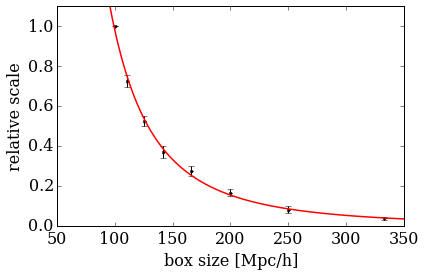

In [11]:
ratiolist = [[] for i in range(len(box_size_this)-1)]
x = 0.5*(rbins[1:]+ rbins[:-1])
for i,nd_log in enumerate(nd_log_list):
    for j in range(len(proxies)):
        for k,r in enumerate(x):
            if r > 1.0 and nd_log > -3.0:
                for l in range(len(box_size_this)-1):
                    ratiolist[l].extend([error[1+l, i,j,k]/error[0, i,j,k]])

ratiolist = np.array(ratiolist)
boxscale = np.insert(np.median(ratiolist,axis=-1),0,1)

def f(boxsize,a, b):
    return a*boxsize**-b
boxpara, boxcov = curve_fit(f, box_size_this, boxscale)

def boxfit(boxsize):
    return boxpara[0]*boxsize**-boxpara[1]

errorbar = np.insert(np.std(ratiolist, axis=-1),0,0)

fig = plt.figure(figsize = (6,4))
plt.errorbar(box_size_this, np.insert(np.mean(ratiolist, axis = -1),0,1),yerr = errorbar, fmt='.',c='k')
xx = np.linspace(95,350,100)
fit = boxfit(xx)
plt.plot(xx,fit, lw=1.5, c='r')

plt.tight_layout(rect=[0.02,0.02,1.0,1.0])
plt.xlabel('box size [Mpc/h]')
plt.ylabel('relative scale')
#plt.title('r dependence of sample variance')
plt.ylim(0,1.1)
#plt.savefig('plots/paper/boxsize_dependence.pdf')

print boxpara, boxcov[1,1]**0.5

def boxfit(boxsize):
    return boxpara[0]*boxsize**-boxpara[1]

def inverse_boxfit(ratio):
    return (ratio/boxpara[0])**(-1./boxpara[1])

In [12]:
def fitfunc(x,a,b,c):
    return a + b*x**-c

def sample_variance(proxy, boxsize, r, nd_log):
    if hasattr(r, '__len__'):
        fit = np.zeros(len(r))
        for i,rr in enumerate(r):
            para = clist[proxies.index(proxy), np.abs(x-rr).argmin()]
            fit[i] = fitfunc(10.**nd_log, para[0], para[1], para[2])*boxfit(boxsize)
        return fit
    para = clist[proxies.index(proxy), np.abs(x-r).argmin()]
    return boxfit(boxsize)*fitfunc(10.**nd_log, para[0], para[1], para[2])

def sample_variance_int(proxy, boxsize, r, nd_log):
    if r == x[-1]:
        return sample_variance(proxy, boxsize, r, nd_log)
    ridx = np.searchsorted(x, r)
    rl, rr = x[ridx-1], x[ridx]
    dl, dr = r - rl, rr- r
    left = sample_variance(proxy, boxsize, rl, nd_log)
    right = sample_variance(proxy, boxsize, rr, nd_log)
    return (left*dr + right*dl)/(rr-rl)


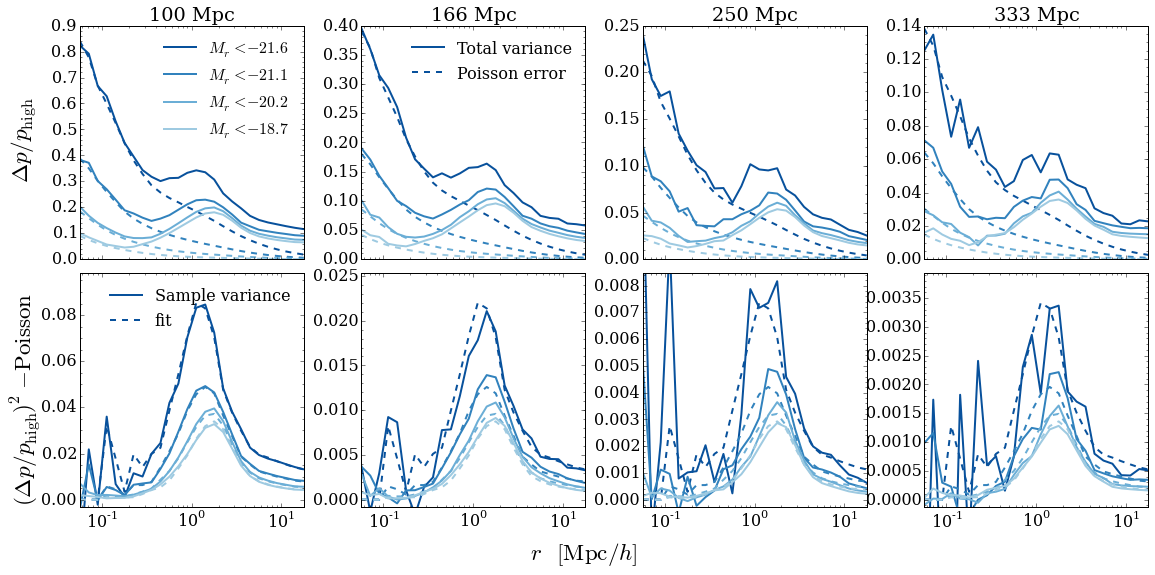

In [13]:
from palettable.colorbrewer.sequential import Blues_6
def get_color(i):
    return Blues_6.mpl_colors[::-1][i]

x = 0.5*(rbins[1:] + rbins[:-1])
proxies = ['vpeak', 'vmax', 'mvir','macc']
nd_log_list_this = (-3.2, -2.7,-2.2, -1.7)
box_size_this = (100., 166., 250., 333.)
case = 'MDhigh'
proxy = 'vpeak'

fig, axarr = plt.subplots(ncols=len(proxies), nrows= 2 , figsize=(4*len(box_size_this), 4.*2), sharex=True, sharey=False)


for i, (ax, box_size) in enumerate(zip(axarr[0], box_size_this)):
    for j, nd_log in enumerate(nd_log_list_this):
        samples = load_samples(proxy, nd_log, box_size, case)
        y = np.std(samples, axis=0)/ np.mean(samples, axis=0)
        y_poisson = 1./np.sqrt(np.mean(samples, axis=0))
        ax.semilogx(x, y, c = get_color(j) , lw=2, label=r'$M_r < {:.1f}$'.format(af.match(10.0**nd_log)) )
        ax.semilogx(x, y_poisson, c = get_color(j) , lw=2,ls='--')
        
    ax.set_xlim(x[0], x[-1])
    #ax.set_ylim(0,0.6)
    ax.minorticks_on()
    ax.set_title('{:d} Mpc'.format(int(box_size)));
    if not i: ax.legend(loc='best', frameon=False, ncol=1, fontsize='medium');
    if i==1: ax.legend(['Total variance','Poisson error'],loc='best', frameon=False, ncol=1, fontsize='medium')

for i, (ax, box_size) in enumerate(zip(axarr[1], box_size_this)):
    for j, nd_log in enumerate(nd_log_list_this):
        samples = load_samples(proxy, nd_log, box_size, case)
        y = np.std(samples, axis=0)/ np.mean(samples, axis=0)
        y_poisson = 1./np.sqrt(np.mean(samples, axis=0))
        yfit = sample_variance(proxy, box_size, x, nd_log)
        ax.semilogx(x, y**2 - y_poisson**2, c = get_color(j) , lw=2)   
        ax.semilogx(x, yfit, c = get_color(j) , lw=2, ls = '--')   
    ax.set_xlim(x[0], x[-1])
    ax.set_ylim(-0.003*boxfit(box_size),0.1*boxfit(box_size))
    if i==0: ax.legend(['Sample variance', 'fit'],loc='best', frameon=False, ncol=1, fontsize='medium')
    ax.minorticks_on()
        
plt.tight_layout(0, rect=(0.03, 0.07, 0.99, 0.98));
fig.text(0.015, 0.75, r'$\Delta p/ p_{\rm high}$', ha='center', va='center', rotation='vertical', fontsize='x-large');
fig.text(0.015, 0.30, r'$(\Delta p/ p_{\rm high})^2 - {\rm Poisson }$', ha='center', va='center', rotation='vertical', fontsize='x-large');
fig.text(0.5, 0.03, r'$r \; [{\rm Mpc}/h]$', ha='center', va='center', fontsize='x-large');
#plt.savefig('plots/paper/sample_variance_poisson_fit.pdf')

## requirement plot

In [14]:
cases = ['c250-2048','c250-1024', 'c250-768', 'c250-512','c125-1024','c400-1024']

Npph_arr = []
nd_log_arr = []
M_list_arr = []
for case in cases:
    m = parse_boxname(case)[2]
    cut = load_nd_limits('mvir', case)
    Npph_arr.extend(cut/m)
    M_list_arr.extend(np.ones_like(cut)*m)
    nd_log_arr.extend(nd_log_list)
Npph_arr = np.array(Npph_arr)
nd_log_arr = np.array(nd_log_arr)
M_list_arr = np.array(M_list_arr)
    
para_nd_M_N = np.polyfit(np.log10(10**-nd_log_arr/M_list_arr), np.log10(Npph_arr),1)
def nd_M_2_Npph(nd_log, M):
    return 10**(para_nd_M_N[0]*(-nd_log-np.log10(M)) +para_nd_M_N[1]) 

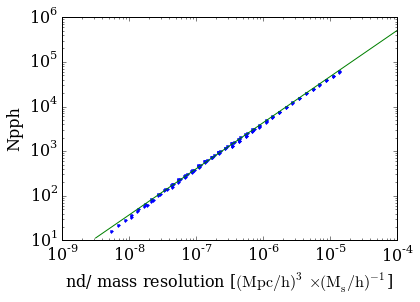

In [20]:
plt.loglog(10**-nd_log_arr/ M_list_arr, Npph_arr, '.')
xx = np.linspace(-8.5, -4., 100)
fit = 10.**(para_nd_M_N[0]*xx + para_nd_M_N[1])
plt.loglog(10.**xx, fit)
plt.xlabel(r'nd/ mass resolution [$ \rm (Mpc/h)^3 \times (M_s/h)^{-1}$]')
plt.ylabel('Npph')
#plt.savefig('plots/nd_m_to_Npph.png')

In [16]:
# the 100. in sample_variance_int specifies that we are matching missing pairs to 0.1*sample variance error
def find_boxsize(proxy, r, nd_log, M, boxmin = 100.):
    Npph = nd_M_2_Npph(nd_log, M)
    ratio =  missing_pairs_int(proxy, Npph, r)**2/ (sample_variance_int(proxy, boxmin, r, nd_log)/100.)
    return inverse_boxfit(ratio)

In [17]:
surveys = {}
surveys['magnitude'] = np.linspace(-22, -17, 11)
surveys['nd'] = af.number_density_at(surveys['magnitude'])
surveys['SDSS'] = np.array([652,537,440,359,291,236,190,153,123,98,79])**3
surveys['z_SDSS'] = np.array([0.237, 0.193,0.157,0.127,0.103,0.0826,0.0664,0.0532,0.0426,0.0340,0.0272])
surveys['GAMA'] = np.array([704,559,444,353,280,223,177,140,112,88.6,70.4])**3
surveys['DESI'] = np.array([1543,1304,1095,912,756,623,510,416,338,273,220])**3
surveys['z_DESI'] = np.array([0.522,0.431,0.354,0.29,0.237,0.193,0.157,0.127,0.103,0.0826,0.0664])

In [18]:
import cosmolopy.distance as cd
from cosmolopy import fidcosmo
from scipy.optimize import fsolve

def f_DESI(x, vol):
    dis = cd.comoving_distance(x, **fidcosmo)*fidcosmo['h']
    return 4.*np.pi/3* dis**3 * 14000./41232. - vol
def f_SDSS(x, vol):
    dis = cd.comoving_distance(x, **fidcosmo)*fidcosmo['h']
    return 4.*np.pi/3* dis**3 * 9000./41232. - vol
def vol2z(vol, s):
    if s=='DESI':
        return fsolve(lambda x: f_DESI(x, vol), x0=0.1, xtol=0.01)[0]
    if s=='SDSS':
        return fsolve(lambda x: f_SDSS(x, vol), x0=0.1, xtol=0.01)[0]

/u/ki/iameric/miniconda/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/u/ki/iameric/miniconda/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


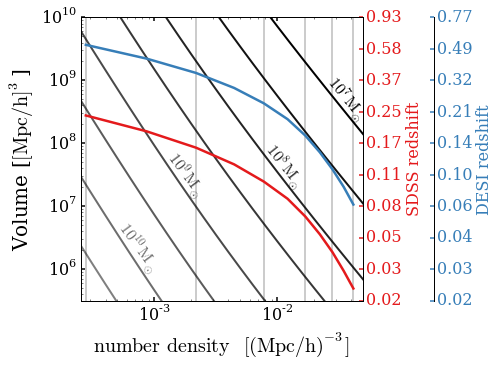

In [19]:
from palettable.colorbrewer.qualitative import Set1_3#RdYlBu_4
def get_color2(i):
    return Set1_3.mpl_colors[-i]
def get_alpha(i):
    return np.linspace(1.,0.,15)[i]

nd_log_list_this = np.linspace(-3.6, -1.3, 24)
xlim = 10.**nd_log_list_this[0], 10.**nd_log_list_this[-1]
ylim = 10.**5.5, 1.e10

proxy = 'vpeak'
r = 1.0
mlist = np.array([1.e7, 3.e7, 1.e8, 3.e8, 1.e9, 3.e9, 1.e10, 3.e10, 1.e11, 3.e11])

fig, host = plt.subplots(figsize = (7,5))
fig.subplots_adjust(right=0.75)
par1 = host.twinx()
par2 = host.twinx()
par2.spines["right"].set_position(("axes", 1.25))

for i,m in enumerate(mlist):
    vol = np.array([find_boxsize(proxy, r, nd_log, m)**3 for nd_log in nd_log_list_this])
    host.loglog(10.**nd_log_list_this, vol,\
             label = r'${0:.1f} \times 10^{{{1}}}$'.format(*frexp10(m)), c='k', alpha = get_alpha(i),lw=2)
    idxlist = np.where((vol - ylim[0])*(vol - ylim[1])<0)[0]
    if len(idxlist)>2 and i%2==0:
        idx = idxlist[len(idxlist)/2]
        slope = (np.log10(vol[idx+1]) - np.log10(vol[idx]))/(nd_log_list_this[idx+1]-nd_log_list_this[idx])
        host.text(10.**nd_log_list_this[idx]*0.9, vol[idx], r'$10^{{{:.0f}}} \rm M_\odot$'.format(np.log10(m)),\
                 rotation = np.arctan(slope)/np.pi*180*0.75, alpha = get_alpha(i))
     
host.loglog(surveys['nd'], surveys['SDSS'], lw = 2.5, label = 'SDSS', c=get_color2(0))
host.loglog(surveys['nd'], surveys['DESI'], lw = 2.5, label = 'DESI', c=get_color2(2))
host.minorticks_on();
#plt.legend(frameon=False, fontsize='small')
for nd in np.linspace(-22, -17, 6):
    host.vlines(af.number_density_at(nd), ylim[0], ylim[1], lw = 0.4)

host.set_ylim(*ylim)
host.set_xlim(*xlim)
par1.set_ylim(*np.log10(ylim))
par2.set_ylim(*np.log10(ylim))
par1.set_ylabel("SDSS redshift")
par2.set_ylabel("DESI redshift")
par1.yaxis.label.set_color(get_color2(0))
par2.yaxis.label.set_color(get_color2(2))
tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors='k', **tkw)

#set the tick labels for the redshift y axis
par1.tick_params(axis='y', colors=get_color2(0), **tkw)
par2.tick_params(axis='y', colors=get_color2(2), **tkw)
host.tick_params(axis='x', **tkw)
par1.locator_params(axis='y',nbins=10)
par2.locator_params(axis='y',nbins=10)
vol1 = par1.get_yticks().tolist()
vol2 = par2.get_yticks().tolist()
z1 = ['{:.2f}'.format(vol2z(10.**v,'SDSS')) for v in vol1]
z2 = ['{:.2f}'.format(vol2z(10.**v,'DESI')) for v in vol2]
par1.set_yticklabels(z1)
par2.set_yticklabels(z2)

host.set_xlabel(r'${\rm number \, density} \; [{{\rm (Mpc/h)}}^{-3}]$', fontsize = 20)
host.set_ylabel(r'Volume [$\rm [Mpc/h]^3$]', fontsize = 20)

plt.tight_layout(0,1.5, rect=(0.01, 0.01, 0.99, 0.99));
#plt.savefig('plots/paper/resolution_requirement_oneplot.pdf')